# Membership inference attack with images
## Target a CNN
Authors : Johan Jublanc

We use this article to simulate a membership inference attack : https://arxiv.org/pdf/1807.09173.pdf

Usefull reference : https://medium.com/disaitek/demystifying-the-membership-inference-attack-e33e510a0c39

### Imports

In [61]:
import numpy as np
import pandas as pd
from sklearn import datasets

from os import listdir
from os.path import isfile, join

import urllib.request

import tarfile

from sklearn import metrics
import xgboost as xgb

from scipy.ndimage import rotate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt

from dp_optimizer_fn import make_gaussian_optimizer_class
import tensorflow as tf

import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib

In [62]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [63]:
# tf.__version__ == 2.x
tf.__version__

'2.2.0-dlenv'

## Get the data from cifar10

We use the CIFAR10 data which is a dataset of color images of size 32x32. For more information let's go here :
- https://www.cs.toronto.edu/~kriz/cifar.html

CIFAR10 data are splited in batches. For this example the first batche is used to build up a classifier and the second one will be used to build up the attack.

In [64]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [65]:
def get_data():
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    data_dir = tf.keras.utils.get_file(origin=url, fname='cifar10', untar=True)

    root_keras_data_path = "/".join(data_dir.split("/")[:5])
    cifar_data_path = os.path.join(root_keras_data_path, "cifar-10-batches-py")

    data_batches_names = []
    for item in os.listdir(cifar_data_path):
        if item.startswith("data_batch"):
            data_batches_names.append(item)
    
    print("Files used to build the data list : ")
    
    data = []
    for data_batches_name in data_batches_names:
        data.append(unpickle(os.path.join(cifar_data_path, data_batches_name)))
        print(data_batches_name)
    
    return data

In [66]:
data = get_data()

Files used to build the data list : 
data_batch_1
data_batch_4
data_batch_3
data_batch_2
data_batch_5


__Split data__

We firstly build a model that is trained on the dataset $data_b$, the dataset $data_a$ is used to evaluate the attack.

In [67]:
x_a = data[0][b"data"]
y_a = data[0][b"labels"]

x_b = data[1][b"data"]
y_b = data[1][b"labels"]

__Get a shadow dataset__

Here the attacker knows another dataset that is similar to D. Here we use batch 2.

In [68]:
x_prim_in = data[2][b"data"]
y_prim_in = data[2][b"labels"]

__Batch 3 is used to get intput out of scope used to train the shadow model__

In [69]:
x_prim_out = data[3][b'data']
y_prim_out = data[3][b'labels']

__Define training parameters__

In [70]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
SHUFFLE_SIZE = 200
NUM_EPOCHS = 1 #300

In [71]:
input_shape = (32, 32, 3)
num_classes = 10
len_train = 10000

In [72]:
train_target = True
train_shadow = True

In [73]:
dropout = False
noise_multiplier = 2

In [74]:
learning_rate = 0.0001

In [75]:
def get_model_name_patterns(dropout, noise_multiplier):
    pattern_target = "models/target" + dropout*"WithDropOut" + "DP" + str(noise_multiplier) + "_*.h5"
    pattern_shadow = "models/shadow" + dropout*"WithDropOut" + "_*.h5"
    print(pattern_target)
    print(pattern_shadow)
    return pattern_target, pattern_shadow

In [76]:
pattern_target, pattern_shadow = get_model_name_patterns(dropout, noise_multiplier)

models/targetDP2_*.h5
models/shadow_*.h5


## Function constituting the whole pipeline :
* reshape images
* create the decay callback
* create a MapDataset
* plt example images
* create a target
* load and save trained models

In [77]:
def reshape_images(flat_array):
    flat_array_normalized = tf.cast(flat_array, tf.float32) / 255.
    img_reshaped = tf.reshape(flat_array_normalized, (3, 32, 32))
    return tf.transpose(img_reshaped)

In [78]:
def scheduler(epoch):
    cycle = epoch // 50
    
    if cycle == 0:
        return 0.001
    elif cycle <= 2:
        return 0.0001
    else:
        return 0.00005

In [148]:
from dp_optimizer_fn import LearningRateScheduler_Perso
callback = LearningRateScheduler_Perso(scheduler)

We define a function to create a dataset tensorflow

In [81]:
def input_fn(flat_arrays, labels, 
             BATCH_SIZE = BATCH_SIZE, 
             SHUFFLE_SIZE = SHUFFLE_SIZE, 
             NUM_EPOCHS = NUM_EPOCHS):
    ds_x = tf.data.Dataset.from_tensor_slices(flat_arrays)
    ds_x = ds_x.map(reshape_images)
    ds_y = tf.data.Dataset.from_tensor_slices(labels)
    ds_x_y = tf.data\
               .Dataset\
               .zip((ds_x, ds_y))\
               .shuffle(SHUFFLE_SIZE)\
               .repeat()\
               .batch(BATCH_SIZE)\
               .prefetch(1)
    return ds_x_y

In [82]:
def plt_img_labels(img_batch, label_batch):
    plt.figure(figsize=(10,10))

    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = rotate(img_batch[n], -90)
        plt.imshow(img)
        plt.title(str(label_batch[n].numpy()))
        plt.axis('off')

A first model is trained on 80% of the $data_b$ and test on the 20% left
We use this article to build a quite good model : https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [83]:
def create_model(input_shape, dropout=dropout, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same', 
                     input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout :
        model.add(Dropout(0.2))
        
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout :
        model.add(Dropout(0.2))
        
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', 
                     padding='same'))
    model.add(MaxPooling2D((2, 2)))
    if dropout :
        model.add(Dropout(0.2))
        
    model.add(Flatten())
    model.add(Dense(128, activation='relu', 
                    kernel_initializer='he_uniform'))
    if dropout :
        model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model

__Load/Save model__

In [84]:
if "models" not in os.listdir():
    os.mkdir("models")

In [85]:
def return_model_num(pattern):
    target_models_list = glob.glob(pattern)
    num_list = [x.split("/")[1].split(".")[0].split("_")[1] for x in target_models_list]
    num_list_int = [int(x) for x in num_list]
    return np.max(num_list_int)

In [86]:
def save_new_model(pattern, model):
    if len(glob.glob(pattern))==0:
        model.save(pattern.split("_")[0] + "_0.h5")
    else:
        num = return_model_num(pattern) + 1
        model.save(pattern.replace("*", str(num)))

In [136]:
def get_model(pattern, input_shape, noise_multiplier=0, dropout=dropout, learning_rate=0.001):
    
    ##################################################
    # create or retrieve model structure and weights #
    ##################################################
    
    model = create_model(input_shape, dropout=dropout, learning_rate=learning_rate)
    
    #if len(glob.glob(pattern))==0:
    #    model = create_model(input_shape, dropout=dropout, learning_rate=learning_rate)
    #    print("\nModel created from scratch")
    #else:
    #    num = return_model_num(pattern)
    #    filepath = pattern.replace("*", str(num))
    #    model = tf.keras.models.load_model(filepath)
    #   print("\nModel retrieved from the file : {}\n".format(filepath))
    
    ####################
    # get the optimizer#
    ####################
    if noise_multiplier > 0 :
        # Use differentrial privacy
        GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
        DPGradientDescentGaussianOptimizer = make_gaussian_optimizer_class(GradientDescentOptimizer)
        noise_multiplier = 2
        optimizer = DPGradientDescentGaussianOptimizer(l2_norm_clip=1,
                                                       noise_multiplier=noise_multiplier,
                                                       learning_rate=learning_rate)
        print("Activation differential privacy, noise multiplier = {}\n".format(noise_multiplier))
        print(optimizer.learning_rate)
    else:
        optimizer = SGD(lr=learning_rate)
    
    ####################
    # compile the model#
    ####################
    print("Manual compilation of the model")
    print("Optimizer : {}".format(optimizer))
    print("Learning rate : {}".format(learning_rate))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['sparse_categorical_accuracy'])
    return model

In [146]:
model = get_model(pattern_target, input_shape, noise_multiplier=2, learning_rate=learning_rate)

Activation differential privacy, noise multiplier = 2

<dp_optimizer_fn.make_gaussian_optimizer_class.<locals>.DPGaussianOptimizerClass object at 0x7f40f05d7890>


In [147]:
model.optimizer.optimizer._learning_rate

0.0001

In [118]:
dir(model.optimizer.__getattribute__('lr'))

['SaveSliceInfo',
 '_OverloadAllOperators',
 '_OverloadOperator',
 '_TensorConversionFunction',
 '__abs__',
 '__add__',
 '__and__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ipow__',
 '__irealdiv__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__

## Train target model

__Create dataset objects__

In [97]:
ds_xy_b = input_fn(x_b, y_b)
ds_xy_a = input_fn(x_a, y_a)

__Plot some example__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


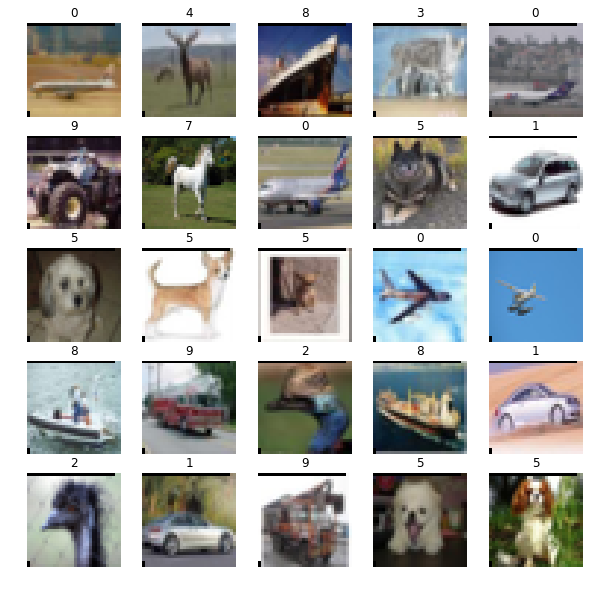

In [98]:
len_train = len(y_b)
img_batch, label_batch = next(iter(ds_xy_b))
plt_img_labels(img_batch, label_batch)

__Load pretrained or create a new model__

In [90]:
def train_and_save_target_model(learning_rate):
    target_model = get_model(pattern_target, input_shape, noise_multiplier=noise_multiplier, learning_rate=learning_rate)
    score = target_model.evaluate(ds_xy_a, steps=200, verbose=0)

    print("\n\nPERFORMANCES BEFORE TRAINNING: ")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history=None
    if train_target:
        history = target_model.fit(ds_xy_b,
                                    epochs=NUM_EPOCHS,
                                    steps_per_epoch=len_train//BATCH_SIZE,
                                    verbose=1,
                                    validation_data=(ds_xy_a),
                                    validation_steps=200,
                                    callbacks=[callback])
        score = target_model.evaluate(ds_xy_a, steps=200, verbose=0)
    
        print("\n\nPERFORMANCES AFTER TRAINNING: ")
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        save_new_model(pattern_target, target_model)
    return history

In [91]:
history = train_and_save_target_model(learning_rate)

Activation differential privacy, noise multiplier = 2

Manual compilation of the model
Optimizer : <dp_optimizer_fn.make_gaussian_optimizer_class.<locals>.DPGaussianOptimizerClass object at 0x7f40f0441210>
Learning rate : 0.0001


PERFORMANCES BEFORE TRAINNING: 
Test loss: 2.306581974029541
Test accuracy: 0.10374999791383743


ValueError: Optimizer must have a "lr" attribute.

__Retrieve the model__

In [ ]:
target_model = get_model(pattern_target, input_shape, noise_multiplier=noise_multiplier)
target_model.summary()

## Train the shadow model

In [ ]:
ds_prim_in = input_fn(x_prim_in, y_prim_in)
ds_prim_out = input_fn(x_prim_out, y_prim_out)

img_batch, label_batch = next(iter(ds_prim_in))
plt_img_labels(img_batch, label_batch)

In [ ]:
def train_and_save_shadow_model(learning_rate):
    model_shadow = get_model(pattern_shadow, input_shape, learning_rate=learning_rate)
    score = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)

    print("\n\nPERFORMANCES BEFORE TRAINING: ")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_shadow = None
    if train_shadow:
        history_shadow = model_shadow.fit(ds_prim_in,
                                      epochs=NUM_EPOCHS,
                                      steps_per_epoch=len_train//BATCH_SIZE,
                                      verbose=1,
                                      validation_data=(ds_prim_out),
                                      validation_steps=200)
        score = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)
        print("\n\nPERFORMANCES AFTER TRAINING: ")
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        
        save_new_model(pattern_shadow, model_shadow)
    return history_shadow

In [ ]:
history_shadow = train_and_save_shadow_model(learning_rate)

In [ ]:
model_shadow = get_model(pattern_shadow, input_shape)
model_shadow.summary()
score = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)

print("\n\nPERFORMANCES BEFORE TRAINING: ")
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Build up the attack

__Build a dataset $D^*$ to train the attack__

Now that we have trained our model on the "in" part of the data, we can make a prediction on both dataset's parts ("in" and "out") a labelise the results. The new dataset is named $D*$

In [ ]:
def input_fn_pred(x):
    ds_x = tf.data.Dataset.from_tensor_slices(x)\
                                  .map(reshape_images)\
                                  .batch(x.shape[0])
    return ds_x

In [ ]:
ds_x_prim_in = input_fn_pred(x_prim_in)
ds_x_prim_out = input_fn_pred(x_prim_out)

In [ ]:
x_star_in = model_shadow.predict(ds_x_prim_in)
y_star_in = [1 for i in range(len(x_star_in))]

x_star_out = model_shadow.predict(ds_x_prim_out)
y_star_out = [0 for i in range(len(x_star_out))]

In [ ]:
x_star = np.concatenate([x_star_in, x_star_out], axis=0)
y_star = np.concatenate([y_star_in, y_star_out], axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
x_star_train, \
x_star_test, \
y_star_train, \
y_star_test = train_test_split(x_star, y_star, test_size =.2)

__Create XGBOOST attack model__

ref : https://www.datacamp.com/community/tutorials/xgboost-in-python#apply

In [ ]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.8,
                                learning_rate = 0.01,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 20)

clf_attack.fit(x_star_train, y_star_train)
print("Accuracy:", metrics.accuracy_score(y_star_test, clf_attack.predict(x_star_test)))

In [ ]:
clf_attack  = xgb.XGBClassifier(objective ='reg:squarederror',
                                colsample_bytree = 0.3,
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 10)
clf_attack.fit(x_star,y_star)

# Test the attack against the true data set D

In [ ]:
def get_predictions_and_labels(target_model, attack_model, data, label):
    
    ds_data = input_fn_pred(data)
    
    # Information we have thanks to the API (original model)
    probas   = target_model.predict(ds_data)

    # Model we have trained to make the attack
    prediction = clf_attack.predict(probas)

    # Results zipping prediction an true labels
    result  = pd.DataFrame(zip(prediction, [label for i in range(len(probas))]), 
                           columns = ("y_pred", "y"))
    
    return result

Results for images out of the training dataset

In [ ]:
results_a = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=clf_attack, 
                                       data=x_a, label=0)

Results for images in the training dataset

In [ ]:
results_b = get_predictions_and_labels(target_model = target_model, 
                                       attack_model=clf_attack,
                                       data=x_b, label=1)

Measure the accuracy of the attack

In [ ]:
attack_results = pd.concat([results_a, results_b]).reset_index().drop("index", axis=1)

In [ ]:
print("Accuracy:", metrics.accuracy_score(attack_results["y"], attack_results["y_pred"]))

## save results

In [ ]:
dataset = "cifar10"
attack_model = "XGBoost"
accuracy_target = target_model.evaluate(ds_xy_a, steps=200, verbose=0)[1]
accuracy_shadow = model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)[1]
accurracy_attack = metrics.accuracy_score(attack_results["y"], attack_results["y_pred"])
DP_multiplicator = 0

In [ ]:
result_dict = {
    "dataset" : ["cifar10"],
    "attack_model" : ["XGBoost"],
    "accuracy_target" : [target_model.evaluate(ds_xy_a, steps=200, verbose=0)[1]],
    "accuracy_shadow" : [model_shadow.evaluate(ds_prim_out, steps=200, verbose=0)[1]],
    "accurracy_attack" : [metrics.accuracy_score(attack_results["y"], attack_results["y_pred"])],
    "DP_multiplicator" : [noise_multiplier],
    "droupout" : [dropout],
    "num_epochs" : [NUM_EPOCHS],
    "learning_rate" : [learning_rate]
}

In [ ]:
result_pd = pd.DataFrame(result_dict)
result_pd

In [ ]:
if "results.csv" in os.listdir("models"):
    main_pd = pd.read_csv("models/results.csv", index_col=0)
    result_pd = pd.concat([main_pd, result_pd], ignore_index=True)

In [ ]:
result_pd

In [ ]:
result_pd.to_csv("models/results.csv")